In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import glob
import os
from tqdm import tqdm
import numpy as np
import cv2

In [2]:
image_size = 256

class ImageDataset(Dataset):
    def __init__(self, paths, transform=None, masked_size=100):
        self.paths = paths
        self.transform = transform
        self.masked_size = masked_size

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")
        masked_img = img.copy()
        masked_img = np.array(masked_img)
        
        if self.transform:
            img = self.transform(img)

        if self.masked_size:
            h = np.random.randint(0, image_size - self.masked_size)
            w = np.random.randint(0, image_size - self.masked_size)
            masked_img[h:h+self.masked_size, w:w+self.masked_size] = 0
            masked_img = Image.fromarray(masked_img)
            masked_img = self.transform(masked_img)

        return img, masked_img
    
    @staticmethod
    def collate_fn(batch):
        image, masked_image = zip(*batch)
        image = torch.stack(image, dim=0)
        masked_image = torch.stack(masked_image, dim=0)
        return image, masked_image

    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dir = "testSet_resize"
image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))  # Adjust the file extension if needed

train_dataset = ImageDataset(image_paths, transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=ImageDataset.collate_fn, pin_memory=True)


In [3]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_size, 0.8))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(out_size, 0.8),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

    
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return F.sigmoid(self.final(u7))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
        )
        self.fc = nn.Linear(13 * 13, 1)

    def forward(self, img):
        x = self.model(img)
        x = x.view(x.size(0), -1)
        x = F.sigmoid(self.fc(x))
        return x

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.MSELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 20

for epoch in tqdm(range(num_epochs)):
    for images, masked_images in train_loader:
        images = images.to(device)
        masked_images = masked_images.to(device)

        # Train the discriminator
        optimizer_D.zero_grad()

        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        outputs = discriminator(images)
        real_loss = criterion(outputs, real_labels)

        fake_images = generator(masked_images)

        outputs = discriminator(fake_images.detach())
        fake_loss = criterion(outputs, fake_labels)

        d_loss = (real_loss + fake_loss) * 0.5
        d_loss.backward()
        optimizer_D.step()

        # Train the generator
        optimizer_G.zero_grad()

        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()


    print(f"[{epoch}/{num_epochs}] Loss_D: {d_loss.item():.4f} Loss_G: {g_loss.item():.4f}")

torch.save(generator.state_dict(), 'generator_basic.pth')
torch.save(discriminator.state_dict(), 'discriminator_basic.pth')


  5%|███████                                                                                                                                      | 1/20 [02:12<42:05, 132.91s/it]

[0/20] Loss_D: 0.0000 Loss_G: 0.9993


 10%|██████████████                                                                                                                               | 2/20 [04:25<39:46, 132.56s/it]

[1/20] Loss_D: 0.0000 Loss_G: 0.9995


 15%|█████████████████████▏                                                                                                                       | 3/20 [06:37<37:31, 132.46s/it]

[2/20] Loss_D: 0.0000 Loss_G: 0.9999


 20%|████████████████████████████▏                                                                                                                | 4/20 [08:49<35:18, 132.41s/it]

[3/20] Loss_D: 0.0000 Loss_G: 0.9999


 25%|███████████████████████████████████▎                                                                                                         | 5/20 [11:15<34:20, 137.33s/it]

[4/20] Loss_D: 0.0000 Loss_G: 0.9998


 30%|██████████████████████████████████████████▎                                                                                                  | 6/20 [13:55<33:47, 144.83s/it]

[5/20] Loss_D: 0.0000 Loss_G: 0.9998


 35%|█████████████████████████████████████████████████▎                                                                                           | 7/20 [16:31<32:11, 148.55s/it]

[6/20] Loss_D: 0.0000 Loss_G: 0.9998


 40%|████████████████████████████████████████████████████████▍                                                                                    | 8/20 [19:07<30:10, 150.87s/it]

[7/20] Loss_D: 0.0000 Loss_G: 0.9999


 45%|███████████████████████████████████████████████████████████████▍                                                                             | 9/20 [21:43<27:59, 152.65s/it]

[8/20] Loss_D: 0.0000 Loss_G: 0.9999


 50%|██████████████████████████████████████████████████████████████████████                                                                      | 10/20 [24:22<25:44, 154.45s/it]

[9/20] Loss_D: 0.0000 Loss_G: 1.0000


 55%|█████████████████████████████████████████████████████████████████████████████                                                               | 11/20 [26:59<23:17, 155.32s/it]

[10/20] Loss_D: 0.0000 Loss_G: 0.9997


 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 12/20 [29:34<20:42, 155.29s/it]

[11/20] Loss_D: 0.0000 Loss_G: 1.0000


 65%|███████████████████████████████████████████████████████████████████████████████████████████                                                 | 13/20 [32:12<18:12, 156.04s/it]

[12/20] Loss_D: 0.0000 Loss_G: 0.9999


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████                                          | 14/20 [34:52<15:42, 157.03s/it]

[13/20] Loss_D: 0.0000 Loss_G: 1.0000


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 15/20 [37:31<13:08, 157.67s/it]

[14/20] Loss_D: 0.0000 Loss_G: 1.0000


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 16/20 [40:02<10:22, 155.67s/it]

[15/20] Loss_D: 0.0000 Loss_G: 1.0000


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 17/20 [42:34<07:43, 154.52s/it]

[16/20] Loss_D: 0.0000 Loss_G: 1.0000


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 18/20 [45:10<05:10, 155.19s/it]

[17/20] Loss_D: 0.0000 Loss_G: 1.0000


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 19/20 [47:46<02:35, 155.25s/it]

[18/20] Loss_D: 0.0000 Loss_G: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [50:25<00:00, 151.25s/it]

[19/20] Loss_D: 0.0000 Loss_G: 1.0000


In [5]:
def color_correction(image, inpainting_mask, inpainting_border=5):
    # Dilate the inpainting mask to include the surrounding area
    kernel = np.ones((inpainting_border, inpainting_border), np.uint8)
    expanded_mask = cv2.dilate(inpainting_mask, kernel, iterations=1)

    # Calculate the mean color of the inpainted region
    inpainted_mean = cv2.mean(image, mask=inpainting_mask)[:3]

    # Calculate the mean color of the surrounding area
    surrounding_mask = cv2.bitwise_xor(expanded_mask, inpainting_mask)
    surrounding_mean = cv2.mean(image, mask=surrounding_mask)[:3]

    # Calculate the color correction factor
    correction_factor = np.array(surrounding_mean) / np.array(inpainted_mean)

    # Apply the color correction to the inpainted region
    corrected_image = image.copy()
    for i in range(3):
        corrected_image[:, :, i] = (corrected_image[:, :, i].astype(np.float32) * correction_factor[i]).clip(0, 255).astype(np.uint8)

    # Combine the corrected inpainted part with the original image
    corrected_image = cv2.add(cv2.bitwise_and(corrected_image, corrected_image, mask=inpainting_mask), cv2.bitwise_and(image, image, mask=cv2.bitwise_not(inpainting_mask)))

    return corrected_image

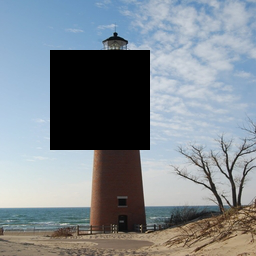

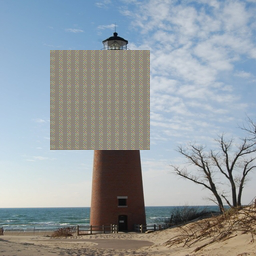

After color correction


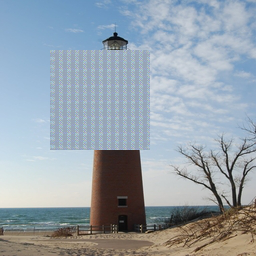

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
generator.load_state_dict(torch.load("generator_basic.pth"))
generator.eval()
image = Image.open("testSet_resize/1.jpg")
image = np.array(image)
image[50:150, 50:150, :] = 0
mask = np.ones((3, 256, 256), dtype=np.uint8)
mask[:, 50:150, 50:150] = 0
image = Image.fromarray(image)
display(image)
image = transform(image).to("cuda")
image = image.unsqueeze(0)
inpaint = generator(image)
inpaint = inpaint.squeeze(0)
inpaint = inpaint.detach().cpu()
inpaint = image.cpu().squeeze(0) * mask + inpaint * (1 - mask)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
inpaint = inpaint * std + mean
inpaint = inpaint.detach().numpy()
inpaint = np.transpose(inpaint, (1, 2, 0))
inpaint = (inpaint * 255).astype(np.uint8)
inpaint1 = inpaint.copy()
mask = np.zeros((256, 256), dtype=np.uint8)
mask[50:150, 50:150] = 255
inpaint1 = color_correction(inpaint1, mask)
inpaint = Image.fromarray(inpaint)
inpaint1 = Image.fromarray(inpaint1)
display(inpaint)
print("After color correction")
display(inpaint1)